# Traffic Sign Recognition

On the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**imports**

In [2]:
import re

In [3]:
from fastai import *
from fastai.vision import *

## Get the data

In [4]:
path = Path('data/gtsrb/')

In [5]:
np.random.seed(2)  # seed ensures that the same validation set is used all the time

**get the original class names**

In [6]:
sign_names = pd.read_csv(path/'sign_names.csv')
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


**change the id's to map to the folder names**

In [7]:
sign_names['ClassId'] =sign_names['ClassId'].apply(
    lambda x: '0000' + str(x) if x < 10 else '000' + str(x))
sign_names.head()

,ClassId,SignName
0,00000,Speed limit (20km/h)
1,00001,Speed limit (30km/h)
2,00002,Speed limit (50km/h)
3,00003,Speed limit (60km/h)
4,00004,Speed limit (70km/h)


In [8]:
sign_names.loc[sign_names['ClassId'] == '00000', 'SignName'].iloc[0]

'Speed limit (20km/h)'

In [9]:
def get_label(x):
    '''
        function maps numerical id to traffic sign name
    '''
    x = str(x)
    match = re.search(r'\d{5}', x).group(0)
    return sign_names.loc[sign_names['ClassId'] == match, 'SignName'].iloc[0]

**create databunch**

In [10]:
src = (ImageItemList.from_folder(path/'train')
        .random_split_by_pct()
        .label_from_func(get_label)
        .add_test(ItemList.from_folder(path/'test')))

In [11]:
tfms = get_transforms(do_flip=False)

In [12]:
data = (src.transform(tfms, size=64)
        .databunch().normalize(imagenet_stats))

In [14]:
len(data.train_ds), len(data.test_ds)

(31368, 12630)

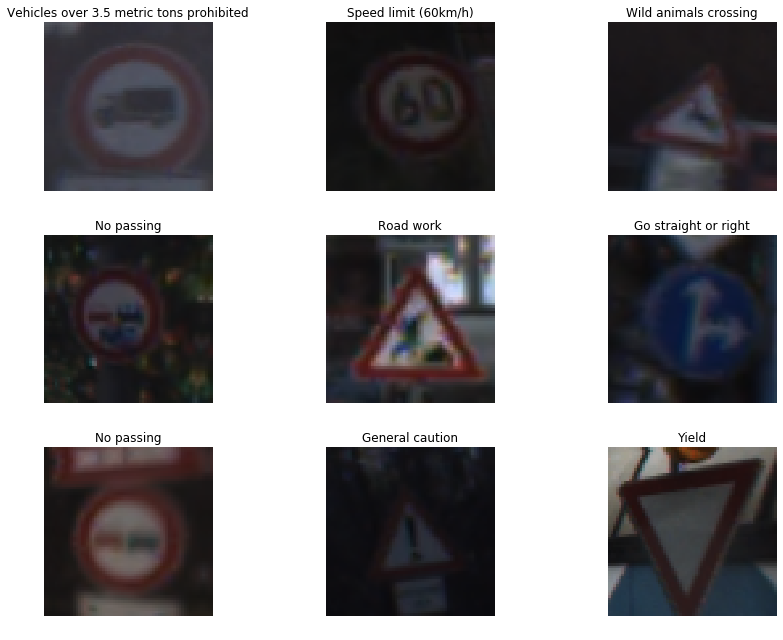

In [18]:
data.show_batch(rows=3, figsize=(12, 9))

In [16]:
data.c  # number of classes

43

## Create the model

In [14]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


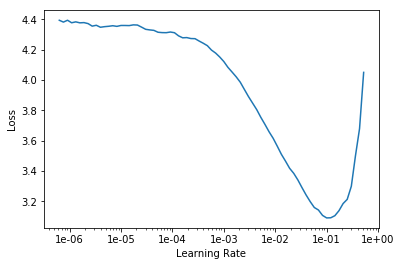

In [17]:
learn.recorder.plot()

In [18]:
lr = 1e-2

In [19]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.883680,0.526374,0.168856
2,0.374654,0.186997,0.062747
3,0.170356,0.062411,0.020023
4,0.122343,0.047795,0.015559
5,0.095576,0.023178,0.007014
6,0.053409,0.020259,0.006377
7,0.032714,0.015529,0.004336
8,0.028484,0.008775,0.002551
9,0.016635,0.008588,0.002551
10,0.010249,0.008326,0.002296


In [20]:
learn.save('stage-1-rn50')

### Unfreeze

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


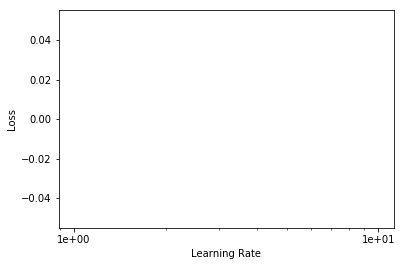

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate
1,0.034062,0.010791,0.003316
2,0.035908,0.012662,0.003061
3,0.022143,0.012001,0.002933
4,0.011796,0.008177,0.001530
5,0.006143,0.008630,0.001658


In [25]:
learn.save('stage-2-rn50')

In [50]:
learn.load('stage-2-rn50');

In [52]:
learn.data  = data

### Progressive resizing: increase the size of images

In [15]:
learn.load('stage-2-rn50');

In [16]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [17]:
learn.data = data

In [38]:
learn.freeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


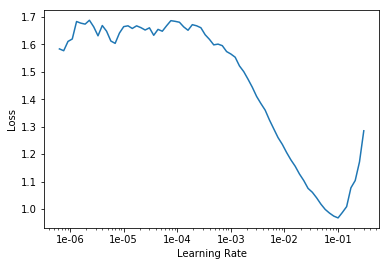

In [40]:
learn.recorder.plot()

In [41]:
lr = 1e-2

In [42]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.149535,0.049931,0.016069
2,0.042957,0.016879,0.005229
3,0.041021,0.023079,0.004974
4,0.051176,0.045253,0.008800
5,0.033353,0.021576,0.003571
6,0.016127,0.004976,0.001403
7,0.015332,0.007054,0.001530
8,0.009066,0.008108,0.001275
9,0.005895,0.005362,0.000893
10,0.001812,0.005236,0.000893


In [43]:
learn.save('stage-1-128-rn50')

In [44]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate
1,0.065388,0.023621,0.006632
2,0.050672,0.012170,0.003571
3,0.013683,0.003481,0.000765
4,0.005871,0.004169,0.001020
5,0.002683,0.003704,0.000765


#### Validation accuracy: 99.999235%

In [47]:
learn.save('stage-2-128-rn50')

## Model interpretation

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

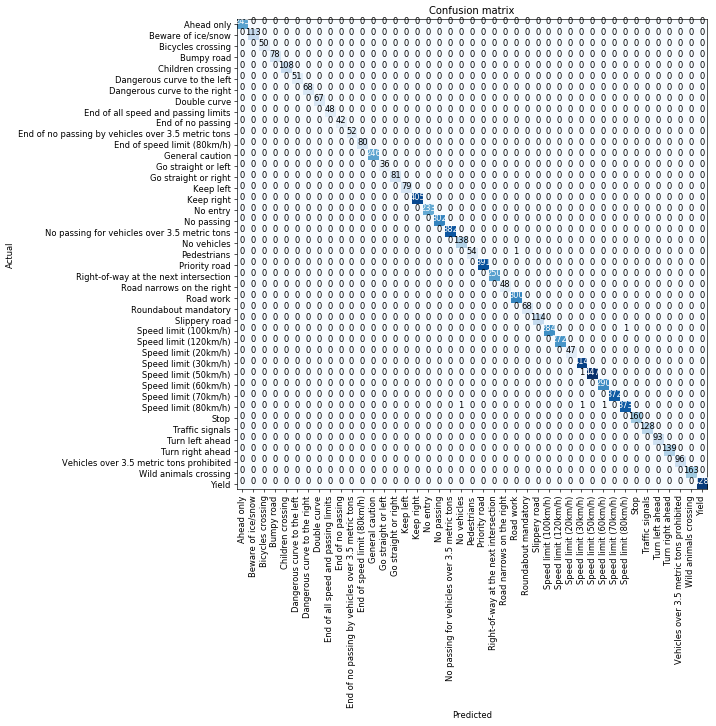

In [32]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

## Evaluate on test set

In [18]:
learn.load('stage-2-128-rn50');

In [19]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [20]:
learn.data = data

**use test time augmentation for prediction on the test set**

In [21]:
preds = learn.TTA(ds_type=DatasetType.Test)[0]
_, predicted_class = torch.max(preds, 1)

**get the ground truth labels for images in the test set**

In [22]:
ground_truth = pd.read_csv(path/'GT-final_test.csv', sep=';', usecols=['Filename', 'ClassId'])
ground_truth.head()

,Filename,ClassId
0,00000.ppm,16
1,00001.ppm,1
2,00002.ppm,38
3,00003.ppm,33
4,00004.ppm,11


In [23]:
def get_row(idx):
    pred = predicted_class[idx].item()
    
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0]
    
    return image_name, pred

#### calculate accuracy

In [24]:
correct = 0
for idx in range(len(preds)):        
    image_name, label = get_row(idx)
    predicted = data.classes[label] # get the label name
    predicted = sign_names.index[sign_names['SignName'] == predicted] # convert label to integer id
    actual = ground_truth.loc[ground_truth['Filename'] == image_name, 'ClassId'].iloc[0]
   
    if predicted == actual: correct += 1

In [25]:
acc = correct / len(data.test_ds)
acc

0.9936658749010293

## Test accuracy is: 99.37%

In [33]:
data.classes

['Ahead only',
 'Beware of ice/snow',
 'Bicycles crossing',
 'Bumpy road',
 'Children crossing',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'End of all speed and passing limits',
 'End of no passing',
 'End of no passing by vehicles over 3.5 metric tons',
 'End of speed limit (80km/h)',
 'General caution',
 'Go straight or left',
 'Go straight or right',
 'Keep left',
 'Keep right',
 'No entry',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'No vehicles',
 'Pedestrians',
 'Priority road',
 'Right-of-way at the next intersection',
 'Road narrows on the right',
 'Road work',
 'Roundabout mandatory',
 'Slippery road',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'Stop',
 'Traffic signals',
 'Turn left ahead',
 'Turn right ahead',
 'Vehicles over 3.5 metric tons prohibited',
 